In [69]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

In [70]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Ready"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [71]:
def ShowPrediction(filename: str, model):
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)
    test_df, predictions = MakeSinglePrediction(file_path, model, labels, NORM_PARAM)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        plt.plot(denormed_time, denormed_label)
        plt.plot(denormed_time, denormed_pred)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

## Importing Model

In [75]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history = LoadModel(model_dir)

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("model_history keys: {}".format(model_history.keys()))

Found 3 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index 	Model-name
  [0]. 	ANN 2022-04-06 06:35:28
  [1]. 	ANN 2022-04-13 11:00:28
  [2]. 	ANN 2022-04-06 06:23:17
You selected model ANN 2022-04-13 11:00:28

model loaded
model history loaded
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


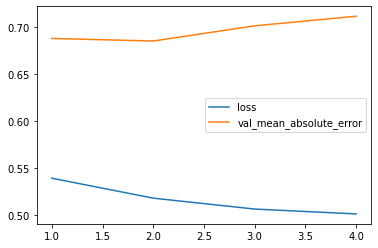

In [77]:
metric = 'mean_absolute_error'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

## Making Few Predictions

## R2 Results

In [7]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,elv_l_rad
count,131.000000
mean,-2.550926
std,8.997959
min,-91.389529
25%,-2.064736
50%,-0.563343
75%,0.331818
max,0.854656


In [40]:
r2_df.nlargest(10, columns=labels)

,filename,elv_l_rad
59,flight_16486.csv,0.854656
30,flight_30791.csv,0.820723
98,flight_36285.csv,0.814484
125,flight_34487.csv,0.769912
53,flight_34315.csv,0.766234
92,flight_31636.csv,0.747887
71,flight_20088.csv,0.715604
11,flight_35320.csv,0.683027
36,flight_30568.csv,0.676803
86,flight_19154.csv,0.673022


In [49]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(24, columns=labels)

,filename,elv_l_rad
127,flight_36060.csv,-91.389529
121,flight_13279.csv,-26.369345
99,flight_32717.csv,-26.259013
2,flight_40943.csv,-18.769950
128,flight_28587.csv,-17.248341
61,flight_32685.csv,-13.313495
75,flight_16365.csv,-12.169917
109,flight_24420.csv,-10.926294
116,flight_39366.csv,-8.459191
25,flight_28940.csv,-8.018904


filename: flight_36060.csv
timespan: 303.0
mae: 8.916664123535156


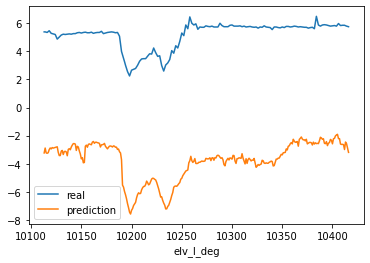

In [68]:
filename_to_predict = "flight_36060.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model)

min: 52.0
max: 439.0
avg: 280.0458015267176


(array([ 2.,  2.,  3.,  0.,  1.,  3.,  3.,  2.,  2.,  2.,  3.,  3.,  2.,
         5.,  9.,  9.,  5., 10.,  6.,  6.,  3.,  5.,  5., 10.,  7.,  9.,
         7.,  4.,  1.,  2.]),
 array([ 52. ,  64.9,  77.8,  90.7, 103.6, 116.5, 129.4, 142.3, 155.2,
        168.1, 181. , 193.9, 206.8, 219.7, 232.6, 245.5, 258.4, 271.3,
        284.2, 297.1, 310. , 322.9, 335.8, 348.7, 361.6, 374.5, 387.4,
        400.3, 413.2, 426.1, 439. ]),
 <BarContainer object of 30 artists>)

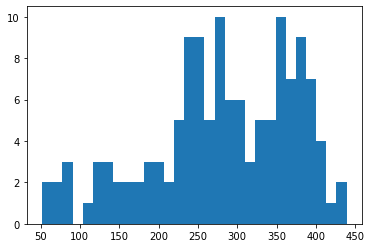

In [47]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [48]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

24